例えば均衡選択メカニズムが安定的な二つの均衡を等確率で選ぶ、というものだった場合、単一均衡の仮定の下で推定される参入確率は不安定な均衡の近くになっちゃわね？っていう疑問を確かめる。

In [32]:
import pandas as pd

df1 = pd.read_csv("1.7--0.5--6.csv", index_col = 0)

In [37]:
# 企業1の参入を回帰する時って、企業2の参入情報もseries煮含めていいのか？→入れてはいけない。が、なぜ？

# case 1: logistic regression
# 各企業のentryprobとlogitの結果によって得られた予想参入確率は、思った通りかなり食い違っている。
#　→複数の均衡が存在するので、参入確率の一致推定ができてない。

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X1 = df1.drop(["entryprob1", "entryprob2", "equitype","single", "entry1", "entry2"], axis = 1)
X2 = df1.drop(["entryprob1", "entryprob2", "equitype","single",  "entry1", "entry2"], axis = 1)
y1 = df1.entry1
y2 = df1.entry2

clf1 = LogisticRegression()
clf1.fit(X1, y1)
coeff1 = pd.DataFrame([X1.columns, clf1.coef_[0]]).T
df1["logit_entry1"] = clf1.predict_proba(X1)[:, 1]

clf2 = LogisticRegression()
clf2.fit(X2, y2)
coeff2 = pd.DataFrame([X2.columns, clf2.coef_[0]]).T
df1["logit_entry2"] = clf2.predict_proba(X2)[:, 1]

df1.head(5)

,pop,dist1,dist2,entryprob1,entryprob2,equitype,entry1,entry2,single,logit_entry1,logit_entry2
0,1.785304,2.490992,0.834502,0.023052,0.922701,0.0,0,1,1,0.169740,0.733779
1,2.147697,2.314002,0.919603,0.845843,0.131954,2.0,1,0,0,0.271353,0.705411
2,1.941536,2.530796,1.679463,0.032224,0.906250,1.0,0,1,0,0.290041,0.602730
3,1.010513,1.382964,1.607856,0.689004,0.038487,2.0,1,1,0,0.403368,0.330694
4,1.133806,1.769167,1.178164,0.028299,0.763185,1.0,0,1,0,0.282508,0.478584


In [34]:
print(coeff1)
print(coeff2)

       0         1
0    pop  0.643226
1  dist1  -1.12532
2  dist2  0.573843
       0         1
0    pop  0.357295
1  dist1  0.852127
2  dist2 -0.715892


In [36]:
# logisticのscore　悪い
print(clf1.score( X1, y1))
print(clf2.score( X2, y2))

0.642008160369
0.606883093844


In [39]:
# case1 はやはり精度が良くない（本質的にはflexibilityよりも、別々の均衡から出た結果を一つの均衡からの結果として推定してしまっているからだけどね。）
# case 2: polynomial (series ) regression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# 企業1
model1 = Pipeline([('poly', PolynomialFeatures(degree=3)), ('linear', LinearRegression(fit_intercept=False))])
model1 = model1.fit(X1, y1)
df1["poly_entry1"] = model1.predict(X1)

# 企業2
model2 = Pipeline([('poly', PolynomialFeatures(degree=3)), ('linear', LinearRegression(fit_intercept=False))])
model2 = model2.fit(X2, y2)
df1["poly_entry2"] = model2.predict(X2)

In [40]:
df1.head(5)

,pop,dist1,dist2,entryprob1,entryprob2,equitype,entry1,entry2,single,logit_entry1,logit_entry2,poly_entry1,poly_entry2
0,1.785304,2.490992,0.834502,0.023052,0.922701,0.0,0,1,1,0.169740,0.733779,0.106989,0.817780
1,2.147697,2.314002,0.919603,0.845843,0.131954,2.0,1,0,0,0.271353,0.705411,0.358373,0.594588
2,1.941536,2.530796,1.679463,0.032224,0.906250,1.0,0,1,0,0.290041,0.602730,0.468981,0.462996
3,1.010513,1.382964,1.607856,0.689004,0.038487,2.0,1,1,0,0.403368,0.330694,0.388450,0.305051
4,1.133806,1.769167,1.178164,0.028299,0.763185,1.0,0,1,0,0.282508,0.478584,0.270573,0.519785


logitとpolynomial regressionのそれぞれを、企業ごとに、本来の参入確率を縦軸として散布図で表示する。

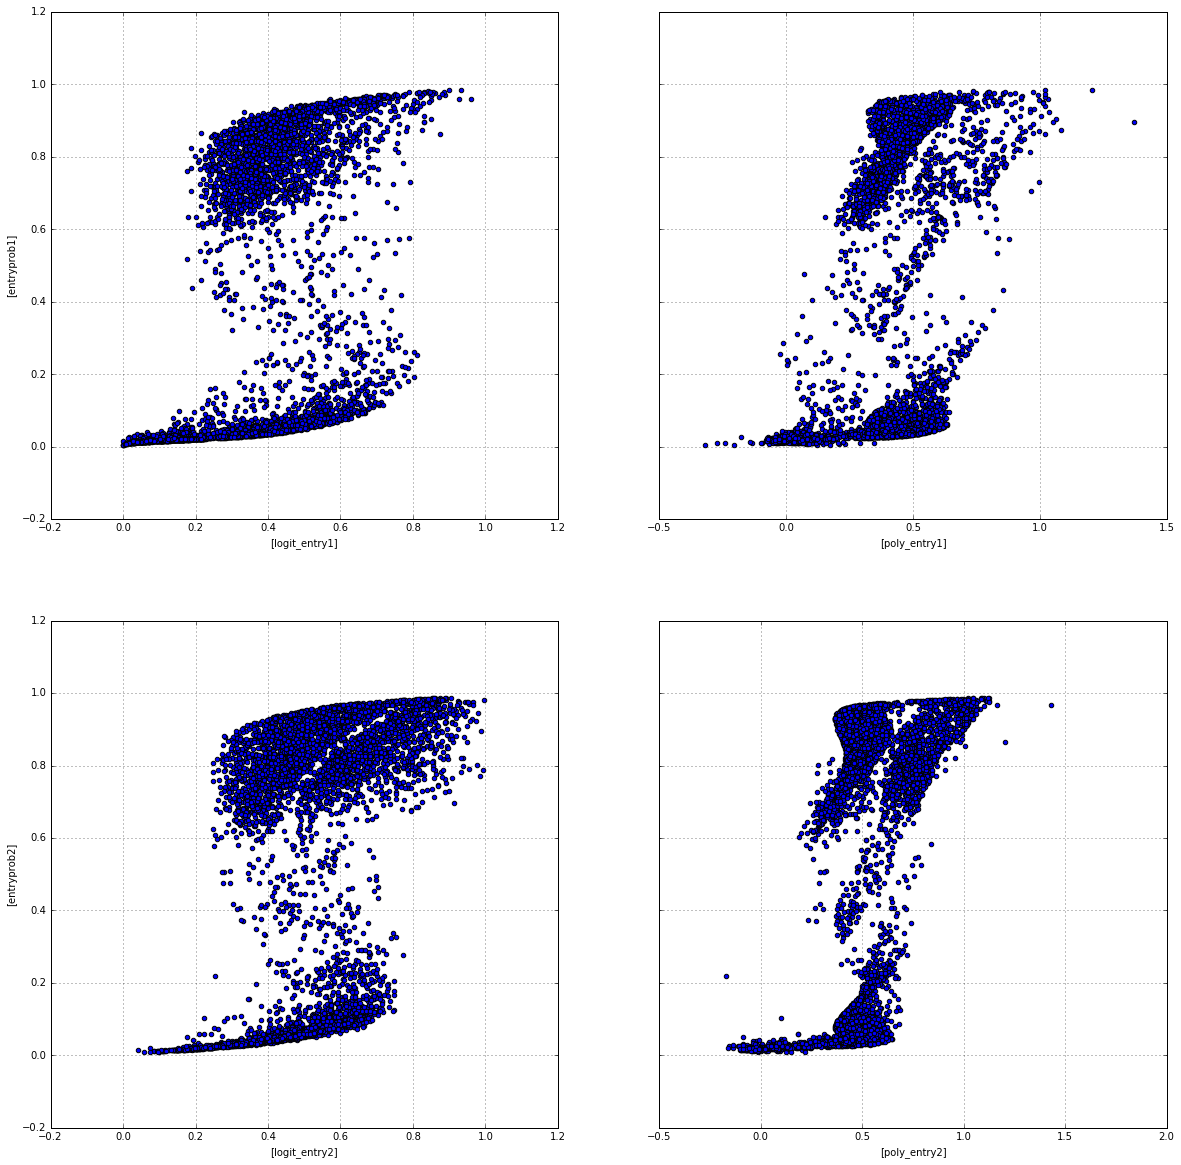

In [62]:
import matplotlib.pyplot as plt
% matplotlib inline

probs1 = df1.loc[:, ["entryprob1", "logit_entry1", "poly_entry1"]]
probs2 = df1.loc[:, ["entryprob2", "logit_entry2", "poly_entry2"]]

fig, axes = plt.subplots(2, len(probs1.columns.values)-1, sharey=True, figsize=(20, 20))

for i, col in enumerate(probs1.columns.values[1:]):
    probs1.plot(x = [col], y = ["entryprob1"], kind="scatter", ax=axes[0, i], grid = True)
    
for i, col in enumerate(probs2.columns.values[1:]):
    probs2.plot(x = [col], y = ["entryprob2"], kind="scatter", ax=axes[1, i], grid = True)

plt.savefig("entryprobs_scatter.png")
plt.show()

参入確率の予測は、本来の参入確率が高い時は低めに、本来の参入確率が低い時は高めに、logitでもpolyでも予測が出ていることがわかる。

モジュール化する

In [3]:
import prediction as pre
import pandas as pd
% matplotlib inline

# read data
df1 = pd.read_csv("1.7--0.5--6.csv", index_col = 0)
df2 = pd.read_csv("1.7--0.5-6.csv", index_col = 0)
df3 = pd.read_csv("1.7--4.5--6.csv", index_col = 0)
df4 = pd.read_csv("1.7--4.5-6.csv", index_col = 0)

# entry probability
df1 = pre.entry_predict(df1)
df2 = pre.entry_predict(df2)
df3 = pre.entry_predict(df3)
df4 = pre.entry_predict(df4)

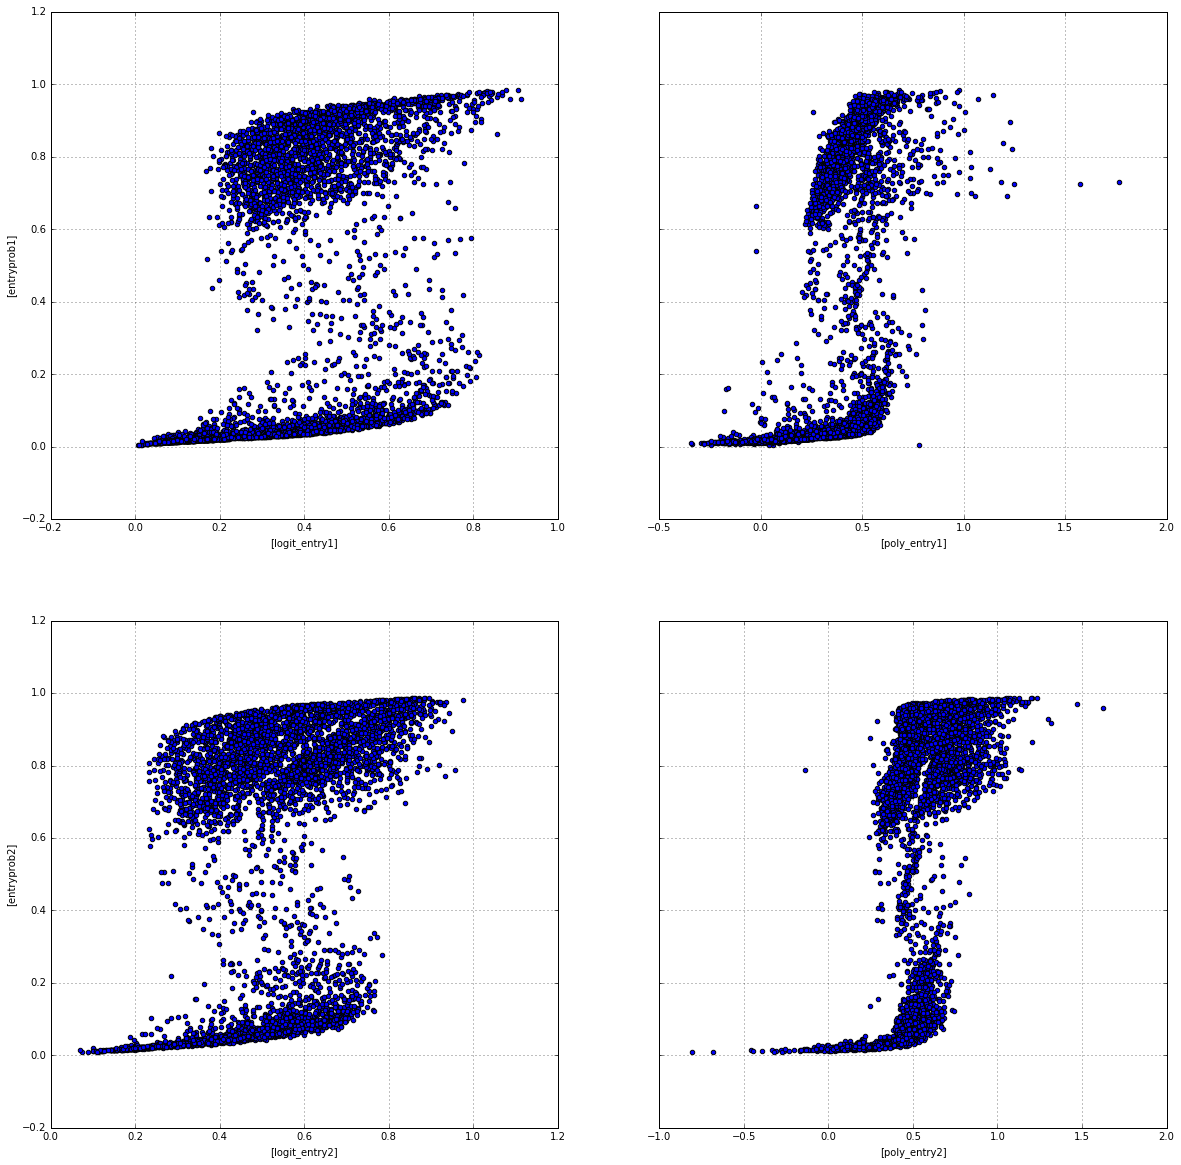

In [4]:
# param1
pre.scatter(df1)

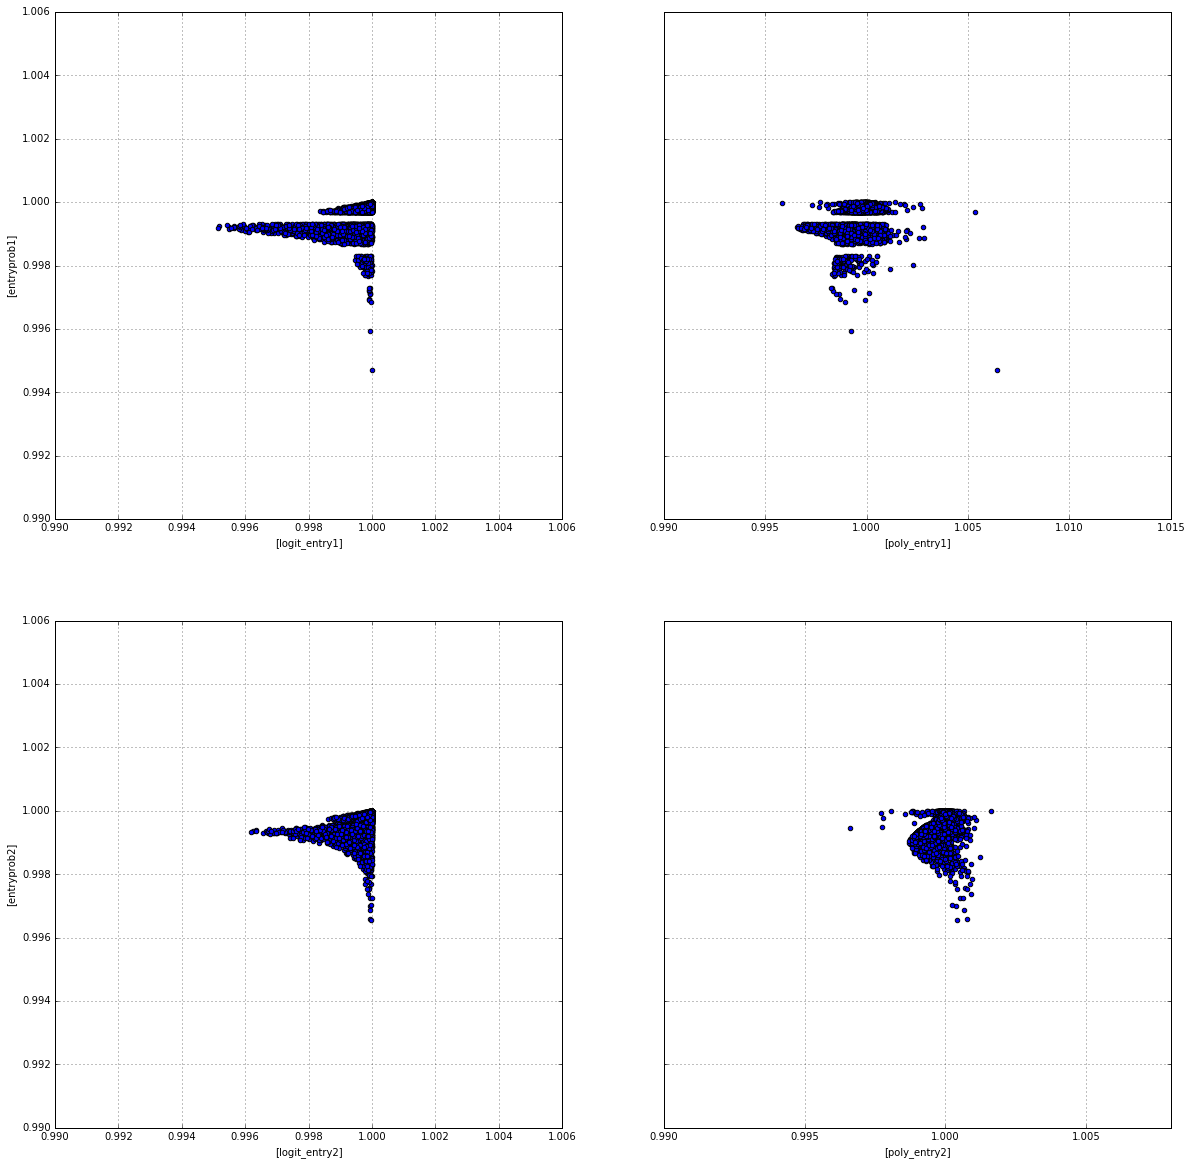

In [5]:
# param2
pre.scatter(df2)

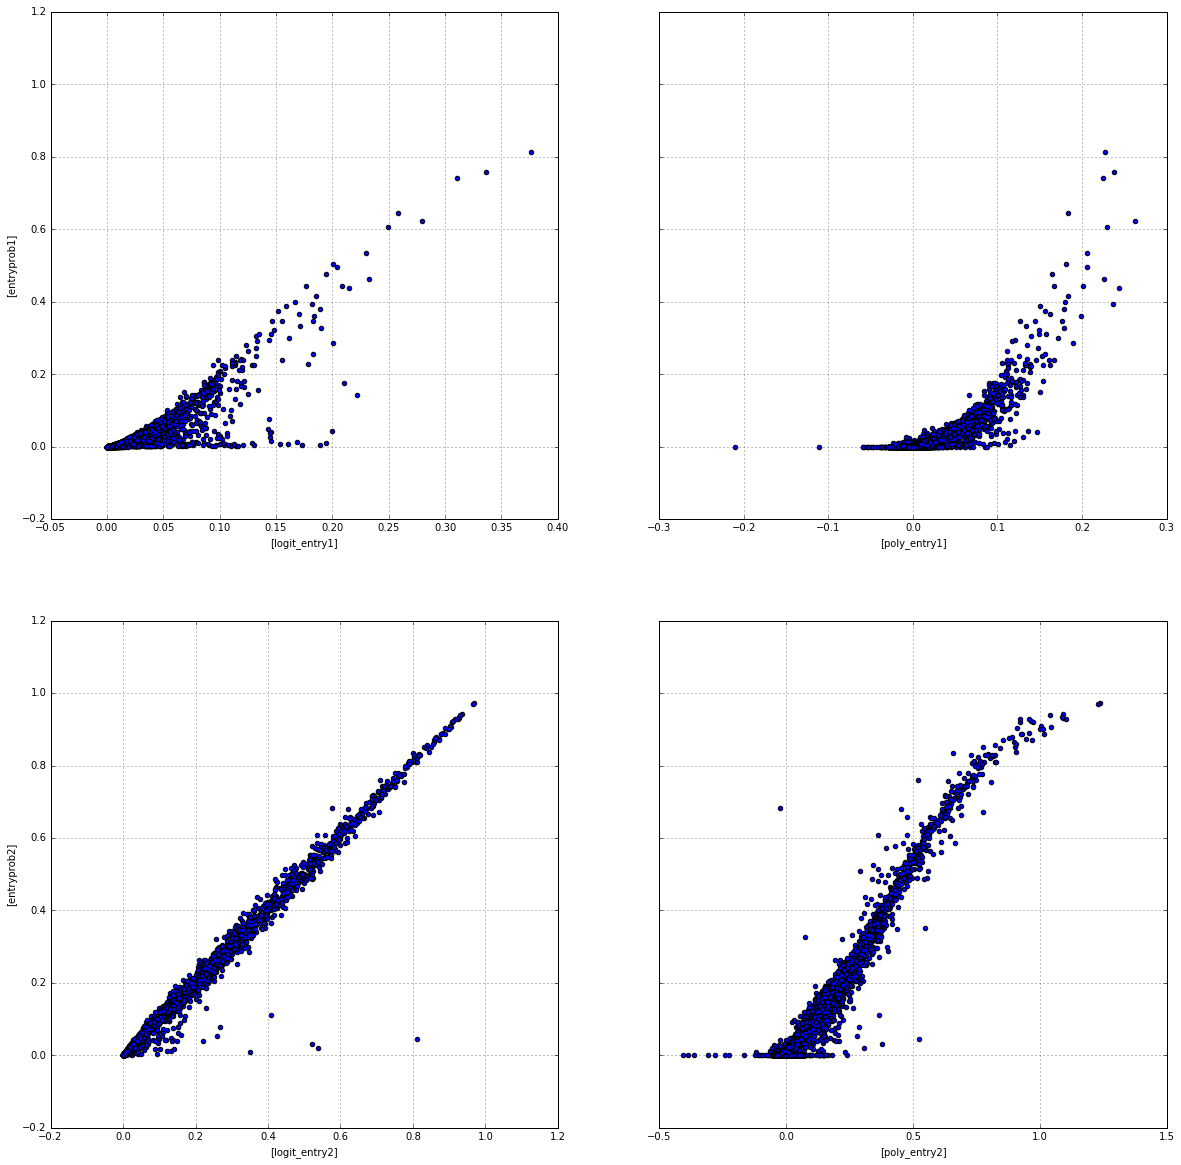

In [6]:
# param3
pre.scatter(df3)

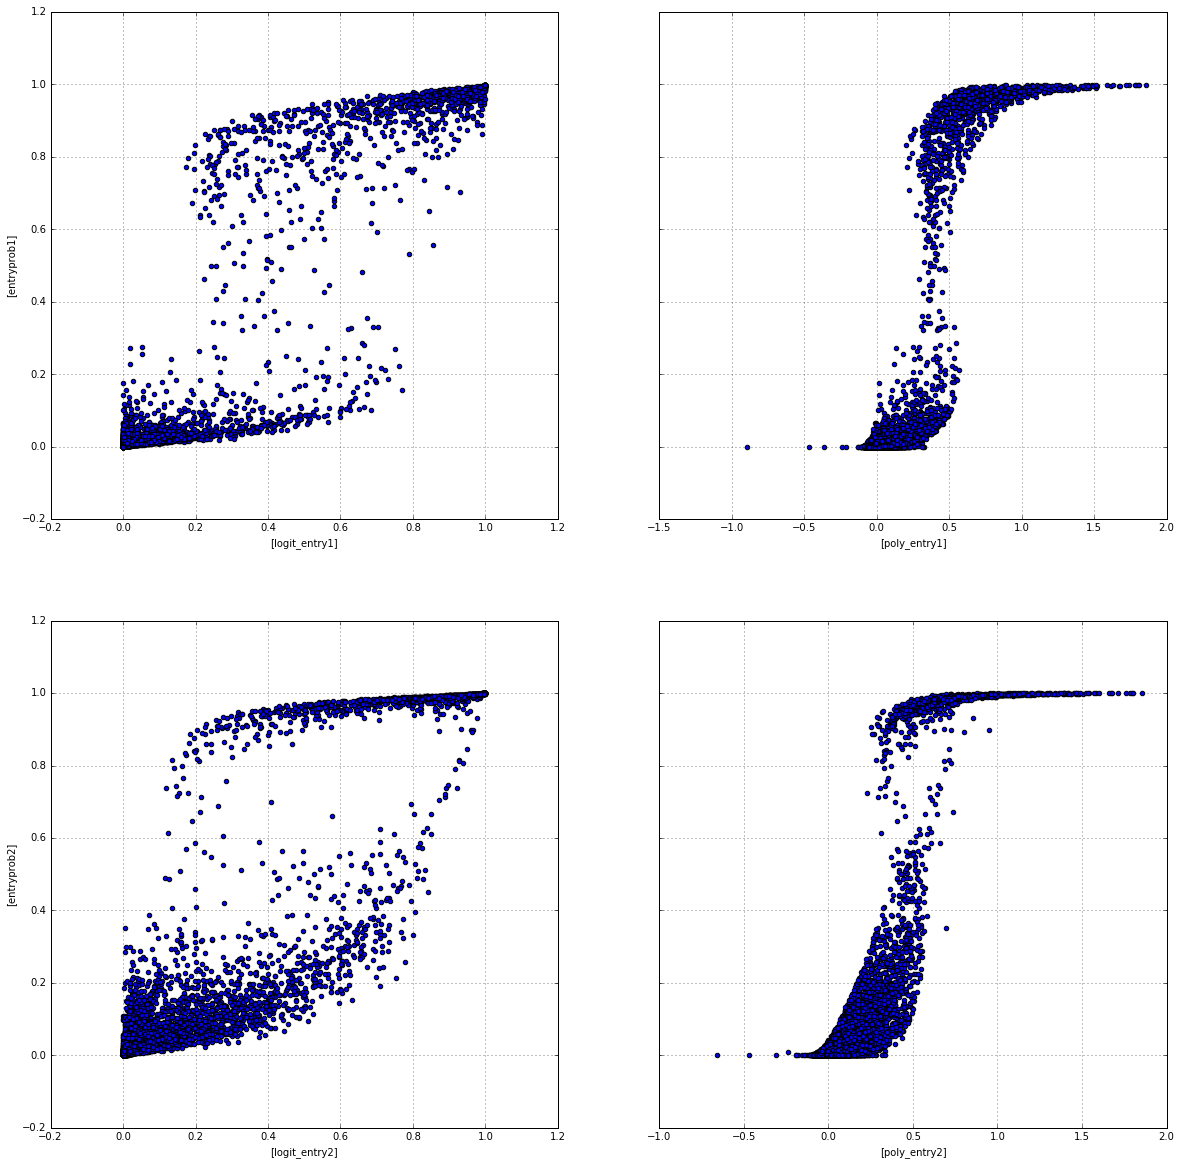

In [7]:
# param4
pre.scatter(df4)